In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [ ]:
!unzip /content/Data_Challenge_PHM2024_test_data.zip
!unzip /content/Data_Challenge_PHM2024_train_data.zip
!unzip /content/Data_Challenge_PHM2024_validation_data.zip

Archive:  /content/Data_Challenge_PHM2024_test_data.zip
replace X_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load datasets from the provided CSV files
X_train = pd.read_csv('/content/X_train.csv').values
X_test = pd.read_csv('/content/X_test.csv').values
X_validation = pd.read_csv('/content/X_validation.csv').values
y_train = pd.read_csv('/content/y_train.csv')

In [ ]:
# Assuming y_train contains two columns: classification and torque margin for regression
y_classification_train = y_train['faulty'].values
y_regression_train = y_train['trq_margin'].values

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

In [ ]:
# Build the neural network for classification and regression
from tensorflow.keras.layers import Input # Import the Input object
from tensorflow.keras.models import Model # Import the Model object

def build_model():
    inputs = Input(shape=(X_train.shape[1],))

    # Shared layers
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)

    # Output 1: Classification (binary)
    classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)

    # Output 2: Regression (torque margin prediction)
    regression_output = Dense(1, activation='linear', name='regression_output')(x)

    # Model with two outputs
    model = Model(inputs=inputs, outputs=[classification_output, regression_output])
    return model

# Compile the model
model = build_model()
model.compile(optimizer='adam',
              loss={'classification_output': 'binary_crossentropy', 'regression_output': 'mse'},
              metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})

model.summary()

# Train the model
history = model.fit(X_train,
                    {'classification_output': y_classification_train, 'regression_output': y_regression_train},
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 64)                   576       ['input_2[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 64)                   0         ['dense_8[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 32)                   2080      ['dropout_4[0][0]']           
                                                                                              

In [ ]:

# Predict on test data
y_pred_class = model.predict(X_test)[0].flatten()
y_pred_reg = model.predict(X_test)[1].flatten()


670/670 [==============================] - 1s 1ms/step


In [ ]:

# Generate PDF predictions
def generate_pdf_predictions(y_pred_reg):
    pdf_type = 'norm'  # You can choose different PDFs like 'cauchy', 'gamma', etc.
    pdf_args = []
    for pred in y_pred_reg:
        loc = pred  # Mean (center) of the distribution
        scale = 0.1  # Standard deviation or scale (can be optimized)
        pdf_args.append({'loc': loc, 'scale': scale})
    return pdf_type, pdf_args


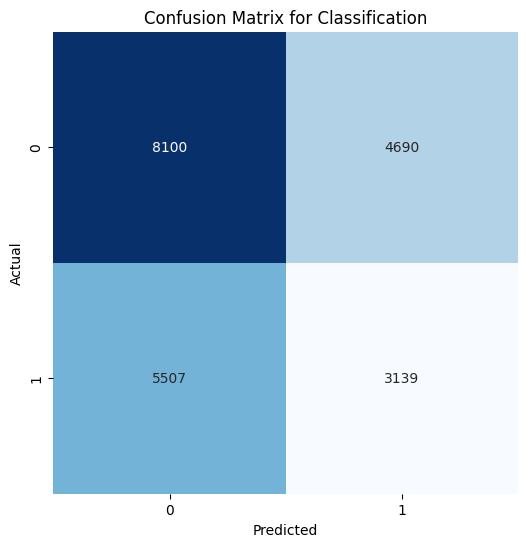


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61     12790
           1       0.40      0.36      0.38      8646

    accuracy                           0.52     21436
   macro avg       0.50      0.50      0.50     21436
weighted avg       0.52      0.52      0.52     21436



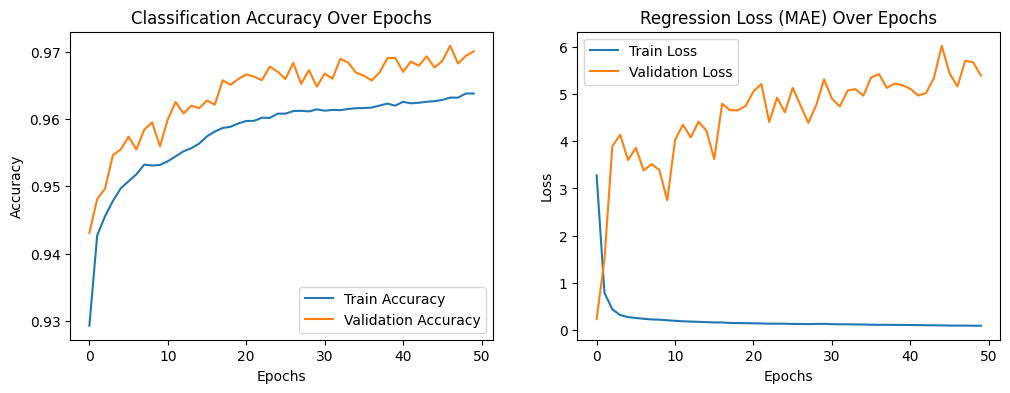


Regression Metrics:
Mean Squared Error (MSE): 277.2862070962895
Mean Absolute Error (MAE): 11.360760617159324
R-squared (R2): -0.40022676535726753


In [ ]:

# Calculate confidence score (0 to 1 range) for classification
def confidence_score(y_pred_class):
    return np.clip(y_pred_class, 0, 1)

# Performance plots and metrics
def plot_metrics(history, y_classification_train, y_pred_class, y_regression_train, y_pred_reg):
    # Classification Metrics: Confusion Matrix and Report
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y_classification_train[:len(y_pred_class)], (y_pred_class >= 0.5).astype(int))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix for Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_classification_train[:len(y_pred_class)], (y_pred_class >= 0.5).astype(int)))

    # Plot model training history (loss/accuracy)
    plt.figure(figsize=(12, 4))

    # Classification Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['classification_output_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_classification_output_accuracy'], label='Validation Accuracy')
    plt.title('Classification Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Regression Loss (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['regression_output_loss'], label='Train Loss')
    plt.plot(history.history['val_regression_output_loss'], label='Validation Loss')
    plt.title('Regression Loss (MAE) Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Regression Metrics
    mse = mean_squared_error(y_regression_train[:len(y_pred_reg)], y_pred_reg)
    mae = mean_absolute_error(y_regression_train[:len(y_pred_reg)], y_pred_reg)
    r2 = r2_score(y_regression_train[:len(y_pred_reg)], y_pred_reg)

    print(f"\nRegression Metrics:\nMean Squared Error (MSE): {mse}\nMean Absolute Error (MAE): {mae}\nR-squared (R2): {r2}")

# Call plot_metrics function
plot_metrics(history, y_classification_train, y_pred_class, y_regression_train, y_pred_reg)


In [ ]:
# Generate submission JSON format
submission = {}
for i in range(len(X_test)):
    class_prediction = int(np.round(y_pred_class[i]))  # Binary classification (0 or 1)
    class_conf = confidence_score(y_pred_class[i])     # Confidence score
    pdf_type, pdf_args = generate_pdf_predictions([y_pred_reg[i]])

    submission[str(i)] = {
        "class": class_prediction,
        "class_conf": float(class_conf),
        "pdf_type": pdf_type,
        "pdf_args": {
            "loc": float(pdf_args[0]['loc']), # Convert loc to float
            "scale": float(pdf_args[0]['scale']) # Convert scale to float
        }
    }

# Save the submission as .jso (JSON format)
with open('submission.jso', 'w') as outfile:
    json.dump(submission, outfile, indent=4)

print("Submission file created successfully!")

Submission file created successfully!
